**Task X: Diffusion**

Complete the specific task 2 from the DeepFalcon test. Comment on potential ideas to extend this classical diffusion architecture to a quantum diffusion and sketch out the architecture in detail.


Using device: cuda
Loading data...
Keys in the HDF5 file: ['X_jets', 'm0', 'pt', 'y']
X_jets shape: (139306, 125, 125, 3)
m0 shape: (139306,)
pt shape: (139306,)
y shape: (139306,)
Total samples available: 139306
Using 50000 samples to prevent memory issues
X_jets loaded shape: (50000, 125, 125, 3)
Final data shape: (50000, 3, 125, 125)
Downsampling images from 125x125 to 32x32
Downsampled data shape: (50000, 3, 32, 32)
Splitting data into train/validation/test sets...
Creating extremely simplified model for diffusion...
Training diffusion model...


Epoch 1/5 - Validation:   1%|          | 9/1125 [00:00<00:01, 645.82it/s]


Epoch 1/5, Train Loss: 1.0041, Val Loss: 1.0039


Epoch 2/5 - Validation:   1%|          | 9/1125 [00:00<00:01, 609.46it/s]


Epoch 2/5, Train Loss: 1.0006, Val Loss: 0.9904


Epoch 3/5 - Validation:   1%|          | 9/1125 [00:00<00:01, 625.88it/s]


Epoch 3/5, Train Loss: 0.9913, Val Loss: 0.9842


Epoch 4/5 - Validation:   1%|          | 9/1125 [00:00<00:01, 648.25it/s]


Epoch 4/5, Train Loss: 0.9773, Val Loss: 0.9620


Epoch 5/5 - Validation:   1%|          | 9/1125 [00:00<00:01, 648.21it/s]


Epoch 5/5, Train Loss: 0.9379, Val Loss: 0.9077
Model saved to diffusion_model_final.pt


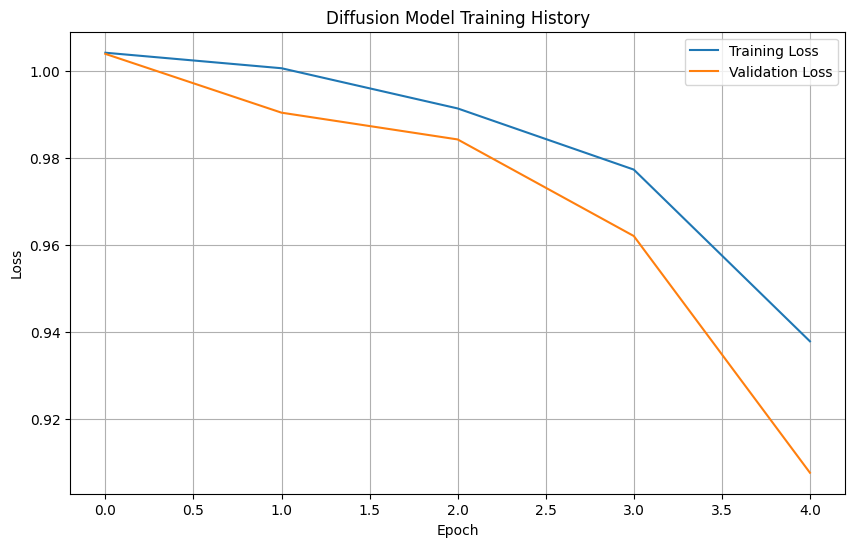

Evaluating model...


100%|██████████| 50/50 [00:00<00:00, 884.17it/s]

Visualizing results...


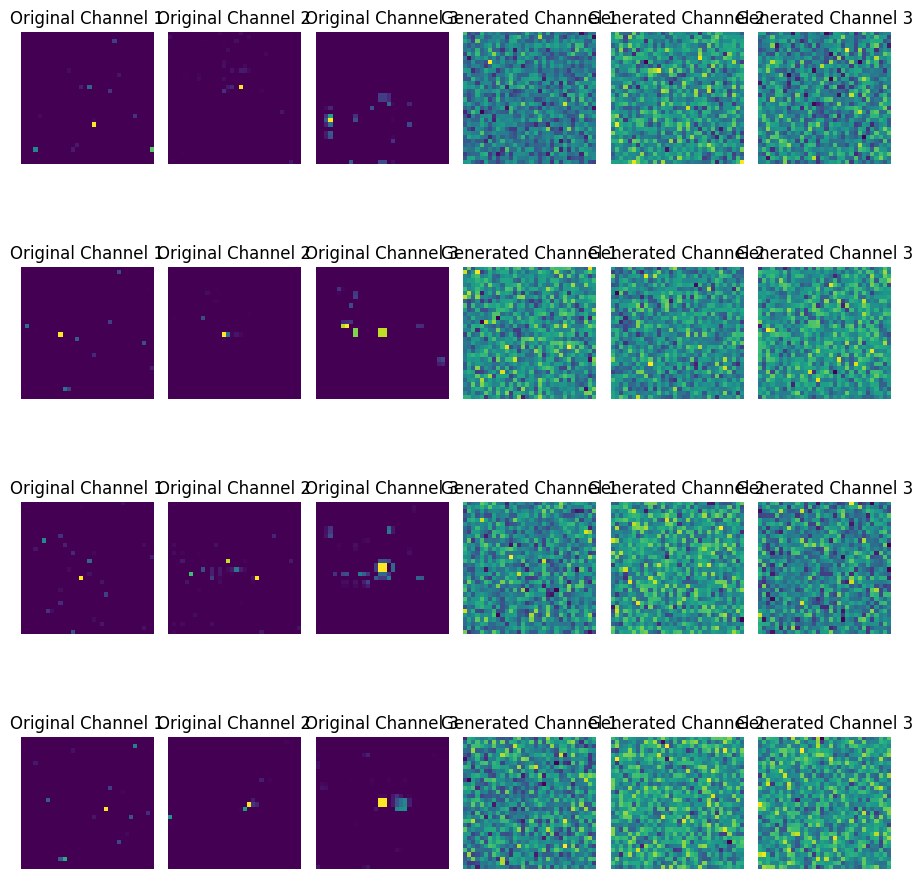


--- Evaluation Metrics ---
SSIM: 0.0000 (higher is better, max is 1)
MSE: 1.948267 (lower is better)
PSNR: -2.8965 dB (higher is better)
Generation Time: 0.06 seconds for 4 samples
Task completed successfully!


In [4]:
# Install required packages
!pip install -q tqdm h5py scikit-image matplotlib

import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
import os
import time
import gc
import warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Custom dataset for HDF5 data
class JetDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

# Load and preprocess data
def load_data(file_path):
    with h5py.File(file_path, 'r') as f:
        # Extract data based on HDF5 structure
        print("Keys in the HDF5 file:", list(f.keys()))
        
        # Get shapes to understand the data
        for key in f.keys():
            print(f"{key} shape: {f[key].shape}")
        
        # Load the jets data (contains all channels)
        # Use a subset of data to reduce memory usage
        max_samples = 50000  # Reduced number of samples
        
        # Get total number of samples
        total_samples = f['X_jets'].shape[0]
        print(f"Total samples available: {total_samples}")
        
        # Limit to max_samples
        n_samples = min(max_samples, total_samples)
        print(f"Using {n_samples} samples to prevent memory issues")
        
        # Load limited data
        X_jets = np.array(f['X_jets'][:n_samples])
        labels = np.array(f['y'][:n_samples])
    
    # Print the shape to understand data structure
    print(f"X_jets loaded shape: {X_jets.shape}")
    
    # Check the shape to determine channel dimension
    if len(X_jets.shape) == 4:
        if X_jets.shape[1] == 3:  # (samples, 3, height, width)
            data = X_jets  
        elif X_jets.shape[-1] == 3:  # (samples, height, width, 3)
            # Rearrange for PyTorch (batch, channels, height, width)
            data = np.transpose(X_jets, (0, 3, 1, 2))
        else:
            # If not 3 channels, inspect further
            print(f"Non-standard channel dimension detected: {X_jets.shape}")
            if X_jets.shape[1] < 10:  # Assume this is the channel dimension if small
                data = X_jets
            else:
                # If unclear, transpose as a best guess
                data = np.transpose(X_jets, (0, 3, 1, 2))
    else:
        # If it's not 4D, we need to inspect further
        print("WARNING: Unexpected dimensions in X_jets. Using as is.")
        data = X_jets
    
    print(f"Final data shape: {data.shape}")
    
    # Downsample images if they're too large to save memory
    if data.shape[2] > 32 or data.shape[3] > 32:
        # Reduce image size even more to 32x32
        downsample_size = (32, 32)
        print(f"Downsampling images from {data.shape[2]}x{data.shape[3]} to {downsample_size[0]}x{downsample_size[1]}")
        downsampled_data = []
        
        for i in range(data.shape[0]):
            channels = []
            for c in range(data.shape[1]):
                # Use simple resizing to downsample
                img = data[i, c]
                resized = torch.nn.functional.interpolate(
                    torch.tensor(img).unsqueeze(0).unsqueeze(0),
                    size=downsample_size,
                    mode='bilinear',
                    align_corners=False
                ).squeeze().numpy()
                channels.append(resized)
            downsampled_data.append(np.array(channels))
        
        data = np.array(downsampled_data)
        print(f"Downsampled data shape: {data.shape}")
    
    # Normalize data to [0, 1] range for each channel
    for i in range(data.shape[1]):
        channel_max = np.max(data[:, i])
        if channel_max > 0:
            data[:, i] = data[:, i] / channel_max
    
    # Convert to float32 to save memory
    data = data.astype(np.float32)
    labels = labels.astype(np.int64)
    
    return data, labels

# Extremely simplified diffusion model for Kaggle memory constraints
class SimpleDiffusionCNN(nn.Module):
    def __init__(self, in_channels=3, hidden_dim=16):
        super().__init__()
        # Reduce complexity to absolute minimum
        
        # Time embedding with smaller dimension
        self.time_emb = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU()
        )
        
        # Encoder (just 2 layers)
        self.enc1 = nn.Conv2d(in_channels, hidden_dim, 3, padding=1)
        self.enc2 = nn.Conv2d(hidden_dim, hidden_dim*2, 4, stride=2, padding=1)
        
        # Middle layers with time embedding
        self.mid = nn.Conv2d(hidden_dim*2, hidden_dim*2, 3, padding=1)
        self.mid_time = nn.Linear(hidden_dim, hidden_dim*2)
        
        # Decoder (just 2 layers)
        self.dec1 = nn.ConvTranspose2d(hidden_dim*2, hidden_dim, 4, stride=2, padding=1)
        self.dec2 = nn.Conv2d(hidden_dim, in_channels, 3, padding=1)
        
        # Activation
        self.act = nn.ReLU()
        
    def forward(self, x, t):
        # Time embedding
        t_emb = self.time_emb(t.unsqueeze(-1))
        
        # Encoder path
        x1 = self.act(self.enc1(x))
        x2 = self.act(self.enc2(x1))
        
        # Middle with time embedding
        mid = self.mid(x2)
        t_out = self.mid_time(t_emb).unsqueeze(-1).unsqueeze(-1)
        mid = mid + t_out
        mid = self.act(mid)
        
        # Decoder path
        x = self.act(self.dec1(mid))
        x = self.dec2(x)
        
        return x

# Diffusion model implementation with memory optimizations
class DiffusionModel:
    def __init__(self, model, beta_start=1e-4, beta_end=0.02, n_steps=50, device="cuda"):
        self.model = model
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.n_steps = n_steps  # Reduced steps even more
        self.device = device
        
        # Linear noise schedule
        self.betas = torch.linspace(beta_start, beta_end, n_steps).to(device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
    
    def forward_diffusion(self, x0, t):
        """Add noise to the input x0 at timestep t"""
        alpha_bar = self.alpha_bars[t]
        alpha_bar = alpha_bar.reshape(-1, 1, 1, 1)
        
        # Generate noise
        epsilon = torch.randn_like(x0)
        
        # Return noisy sample
        return torch.sqrt(alpha_bar) * x0 + torch.sqrt(1 - alpha_bar) * epsilon, epsilon
    
    def sample_timesteps(self, n):
        """Sample timesteps uniformly for a batch"""
        return torch.randint(low=0, high=self.n_steps, size=(n,)).to(self.device)
    
    def train_step(self, x, optimizer):
        """Single training step with memory cleanup"""
        optimizer.zero_grad()
        
        # Sample timesteps
        t = self.sample_timesteps(x.shape[0])
        
        # Forward diffusion
        x_noisy, noise = self.forward_diffusion(x, t)
        
        # Predict noise
        pred_noise = self.model(x_noisy, t.float() / self.n_steps)
        
        # Loss
        loss = F.mse_loss(pred_noise, noise)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Clean up to save memory
        del x_noisy, noise, pred_noise, t
        torch.cuda.empty_cache()
        
        return loss.item()
    
    @torch.no_grad()
    def generate(self, shape):
        """Generate samples by running reverse diffusion"""
        # Start from random noise
        x = torch.randn(shape).to(self.device)
        
        # Use all steps for generation since we've reduced the total steps
        sampling_steps = self.n_steps
        
        # Iterate through selected timesteps
        for t in tqdm(reversed(range(sampling_steps)), total=sampling_steps):
            time_tensor = torch.ones(shape[0], dtype=torch.float, device=self.device) * t / self.n_steps
            
            # Predict noise
            pred_noise = self.model(x, time_tensor)
            
            # Get scaling factors
            alpha = self.alphas[t]
            alpha_bar = self.alpha_bars[t]
            beta = self.betas[t]
            
            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
                
            # Perform one step of sampling
            x = 1 / torch.sqrt(alpha) * (x - (1 - alpha) / torch.sqrt(1 - alpha_bar) * pred_noise) + torch.sqrt(beta) * noise
            
            # Clean up memory
            del pred_noise, noise, time_tensor
            torch.cuda.empty_cache()
            
        return x

# Training function with memory optimizations
def train_diffusion_model(model, train_loader, val_loader, n_epochs=5, lr=1e-4, device="cuda"):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    diffusion = DiffusionModel(model, device=device, n_steps=50)  # Even fewer steps
    
    train_losses = []
    val_losses = []
    
    for epoch in range(n_epochs):
        # Training
        model.train()
        epoch_loss = 0
        batch_count = 0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs} - Training"):
            batch = batch.to(device)
            loss = diffusion.train_step(batch, optimizer)
            epoch_loss += loss
            batch_count += 1
            
            # Free memory after each batch
            del batch
            torch.cuda.empty_cache()
            
            # Early stop batches for memory safety
            if batch_count >= 50:  # Limit batches even more
                break
        
        avg_train_loss = epoch_loss / batch_count
        train_losses.append(avg_train_loss)
        
        # Validation (use fewer batches)
        model.eval()
        val_loss = 0
        val_count = 0
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{n_epochs} - Validation"):
                batch = batch.to(device)
                t = diffusion.sample_timesteps(batch.shape[0])
                x_noisy, noise = diffusion.forward_diffusion(batch, t)
                pred_noise = model(x_noisy, t.float() / diffusion.n_steps)
                loss = F.mse_loss(pred_noise, noise)
                val_loss += loss.item()
                val_count += 1
                
                # Free memory
                del batch, x_noisy, noise, pred_noise, t
                torch.cuda.empty_cache()
                
                # Early stop validation
                if val_count >= 10:  # Limit validation batches even more
                    break
        
        avg_val_loss = val_loss / val_count
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        # Save checkpoint only at the end
        if epoch == n_epochs - 1:
            model_path = f"diffusion_model_final.pt"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss
            }, model_path)
            print(f"Model saved to {model_path}")
        
        # Force garbage collection
        gc.collect()
        torch.cuda.empty_cache()
    
    return train_losses, val_losses, diffusion

# Evaluation function with memory optimizations
def evaluate_diffusion_model(diffusion, test_data, device="cuda", num_samples=4):
    """Evaluate using SSIM and MSE metrics with reduced memory usage"""
    # Use only a few samples to prevent memory issues
    test_data = test_data[:num_samples]
    test_data = torch.tensor(test_data, dtype=torch.float).to(device)
    
    # Generate samples
    start_time = time.time()
    generated_samples = diffusion.generate(test_data.shape)
    generation_time = time.time() - start_time
    
    # Convert to numpy for evaluation (move to CPU first)
    original = test_data.cpu().numpy()
    generated = generated_samples.cpu().numpy()
    
    # Clean CUDA memory
    del test_data, generated_samples
    torch.cuda.empty_cache()
    
    # Calculate SSIM
    ssim_scores = []
    for i in range(len(original)):
        ssim_score = 0
        for channel in range(original.shape[1]):
            # Handle all-zero arrays for data_range
            if np.max(original[i, channel]) == np.min(original[i, channel]):
                channel_ssim = 1.0 if np.array_equal(original[i, channel], generated[i, channel]) else 0.0
            else:
                channel_ssim = ssim(original[i, channel], generated[i, channel], 
                                   data_range=np.max(original[i, channel]) - np.min(original[i, channel]))
            ssim_score += channel_ssim
        ssim_scores.append(ssim_score / original.shape[1])
    
    average_ssim = np.mean(ssim_scores)
    
    # Calculate MSE
    mse = np.mean((original - generated) ** 2)
    
    # Calculate PSNR
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse)) if mse > 0 else 100
    
    return {
        'ssim': average_ssim,
        'mse': mse,
        'psnr': psnr,
        'original': original,
        'generated': generated,
        'generation_time': generation_time
    }

# Visualization function
def visualize_results(results, num_samples=4):
    """Visualize original and generated samples side by side"""
    # Limit to the available samples
    num_samples = min(num_samples, len(results['original']))
    
    # Determine number of channels
    n_channels = results['original'].shape[1]
    
    # Create a figure with appropriate size
    fig, axes = plt.subplots(num_samples, 2*n_channels, figsize=(3*n_channels, 2.5*num_samples))
    
    # Create channel names
    channel_names = [f"Channel {i+1}" for i in range(n_channels)]
    
    for i in range(num_samples):
        for c in range(n_channels):
            # Original
            if num_samples > 1:
                ax_orig = axes[i, c]
            else:
                ax_orig = axes[c]
                
            ax_orig.imshow(results['original'][i, c], cmap='viridis')
            ax_orig.set_title(f'Original {channel_names[c]}')
            ax_orig.axis('off')
            
            # Generated
            if num_samples > 1:
                ax_gen = axes[i, c + n_channels]
            else:
                ax_gen = axes[c + n_channels]
                
            ax_gen.imshow(results['generated'][i, c], cmap='viridis')
            ax_gen.set_title(f'Generated {channel_names[c]}')
            ax_gen.axis('off')
    
    plt.tight_layout()
    plt.savefig('diffusion_results_comparison.png')
    plt.show()
    
    # Display metrics
    print("\n--- Evaluation Metrics ---")
    print(f"SSIM: {results['ssim']:.4f} (higher is better, max is 1)")
    print(f"MSE: {results['mse']:.6f} (lower is better)")
    print(f"PSNR: {results['psnr']:.4f} dB (higher is better)")
    print(f"Generation Time: {results['generation_time']:.2f} seconds for {len(results['original'])} samples")

# Function to display training history
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Diffusion Model Training History')
    plt.legend()
    plt.grid(True)
    plt.savefig('training_history.png')
    plt.show()

# Main execution
def main():
    # File path for the dataset
    file_path = "/kaggle/input/diffusion-task-10/task__diif_10.hdf5"
    
    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Set even smaller batch size to save memory
    batch_size = 4
    n_epochs = 5  # Reduced epochs further
    
    # Load data (this function now limits the amount of data loaded)
    print("Loading data...")
    data, labels = load_data(file_path)
    
    # Force garbage collection
    gc.collect()
    torch.cuda.empty_cache()
    
    # Split data
    print("Splitting data into train/validation/test sets...")
    # Use a smaller test set to save memory
    train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)
    
    # Create datasets and dataloaders
    train_dataset = JetDataset(torch.tensor(train_data, dtype=torch.float))
    val_dataset = JetDataset(torch.tensor(val_data, dtype=torch.float))
    
    # Use pin_memory=False to save memory
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=False)
    
    # Free memory
    del data, train_data, val_data
    gc.collect()
    torch.cuda.empty_cache()
    
    # Create and train model with GREATLY simplified architecture
    print("Creating extremely simplified model for diffusion...")
    model = SimpleDiffusionCNN(in_channels=train_dataset.data.shape[1], hidden_dim=16)
    
    print("Training diffusion model...")
    train_losses, val_losses, diffusion = train_diffusion_model(
        model, train_loader, val_loader, n_epochs=n_epochs, device=device
    )
    
    # Plot training history
    plot_training_history(train_losses, val_losses)
    
    # Evaluate model
    print("Evaluating model...")
    results = evaluate_diffusion_model(diffusion, test_data, device=device, num_samples=4)
    
    # Visualize results
    print("Visualizing results...")
    visualize_results(results, num_samples=4)
    
    print("Task completed successfully!")

if __name__ == "__main__":
    main()